In [73]:
import os
import ssl
import urllib.request

import cv2
import numpy as np
import logging
import imageio
from skimage import io
from matplotlib import pyplot as plt

from fastapi import FastAPI, BackgroundTasks, Request
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import FileResponse, JSONResponse
from PIL import Image, ImageFilter

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import torch
from skimage import filters
import subprocess
from fastapi.middleware.cors import CORSMiddleware
from numpy import asarray
from PIL import Image, ImageOps

In [74]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [75]:
def get_best_mask(img: Image):
    array_image = np.asarray(img)

    predictor = SamPredictor(sam)
    predictor.set_image(array_image)

    input_point = np.array([[600, 400], [525, 600], [425, 600]])
    input_label = np.array([1, 1, 0])

    masks, scores, logits = predictor.predict(
    multimask_output=True,
    point_coords=input_point,
    point_labels=input_label,
    )
    masks.shape 
    best_mask = masks
    currentScore = 0

    for i, (mask, score) in enumerate(zip(masks, scores)):
        if (score > currentScore):
            currentScore = score
            best_mask = mask

    return best_mask

In [105]:
def cut_image(best_mask: Image):
    mask = Image.fromarray(best_mask)

    # Threshold and invert the colors (white will be transparent)
    mask = mask.point(lambda x: x > 100 and 255)

    # The size of the images must match before apply the mask
    img = ImageOps.fit(Image.open('pictures/woman.jpg'),mask.size)

    img.putalpha(mask) # Modifies the original image without return

    return img

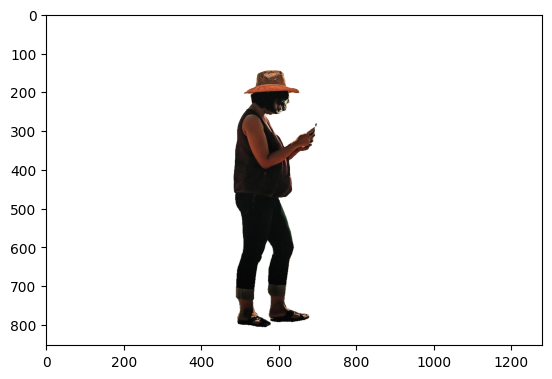

In [106]:
image = Image.open('pictures/woman.jpg')
"""
img = cv2.cvtColor(cv2.imread('pictures/woman.jpg'), cv2.COLOR_BGR2RGB)


best_mask = get_best_mask(img)

# Assuming 'image' is your original image and 'segmentation_mask' is the mask image
binary_mask = np.where(best_mask > 0.5, 1, 0)

# Create a new image with the same size and RGBA format
new_image = np.zeros((img.shape[0], img.shape[1], 4))

# Use the binary mask to combine the original image and the transparency
new_image[..., :3] = img * binary_mask[..., np.newaxis]
new_image[..., 3] = binary_mask * 255


# Save the result as a PNG file
#cv2.imwrite('new_dog_img.png', new_image)
new_image = new_image / 255

cv2.imwrite('new_dog_img.png', new_image)

plt.imshow(new_image)
plt.show()"""

from PIL import Image, ImageOps
img = cv2.cvtColor(cv2.imread('pictures/woman.jpg'), cv2.COLOR_BGR2RGB)

best_mask = get_best_mask(img)
# Convert to grayscale
img = cut_image(best_mask)

img.save('result2.png')
plt.imshow(img)
plt.show()

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    i = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    i[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.8]])
        i[m] = color_mask
    ax.imshow(i)
    return i

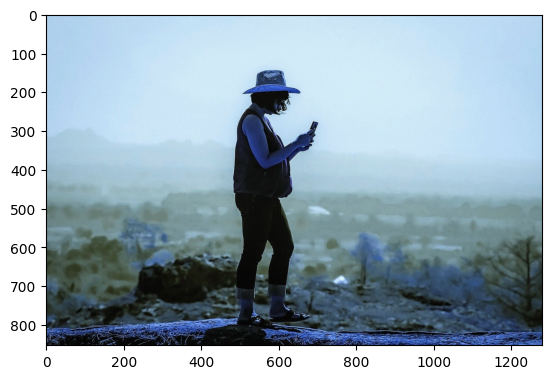

In [83]:
from numpy import asarray

mask_generator = SamAutomaticMaskGenerator(sam)
#img_float32 = np.float32(new_image)
#Image_try = Image.fromarray(img_float32)
image2 = cv2.cvtColor(asarray(img), cv2.COLOR_BGR2RGB)

plt.imshow(image2)
plt.show()


In [85]:
nd_array_image = asarray(image2)

masks = mask_generator.generate(image2)
print(len(masks))
print(masks[0].keys())

91
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


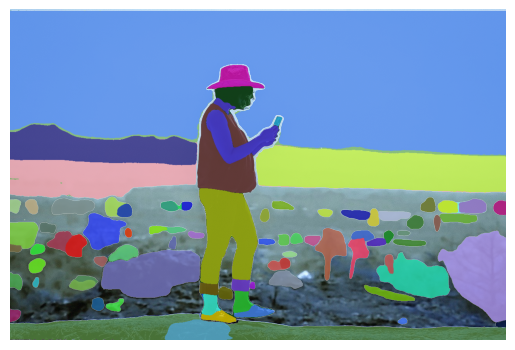

In [87]:
plt.imshow(image2)
test = show_anns(masks)
plt.axis('off')
plt.show()          

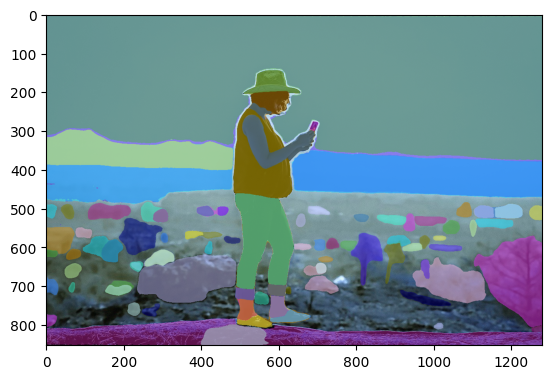

TypeError: Figure.savefig() missing 1 required positional argument: 'fname'

<Figure size 640x480 with 0 Axes>

In [102]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(masks)
annotated_image = mask_annotator.annotate(image2, detections)

plt.imshow(annotated_image)
plt.show()


x = plt.savefig()

plt.imshow(x, "x.png")
plt.show()

In [109]:
i = 0
#image2 = cv2.cvtColor(asarray(img), cv2.COLOR_BGR2RGBA)
for m in masks:    
    edge_sobel = filters.sobel(m['segmentation'])
    cv2.cvtColor(asarray(edge_sobel), cv2.COLOR_BGR2RGBA)
    edge_img = Image.fromarray(edge_sobel)

    cv2.cvtColor(asarray(img), cv2.COLOR_BGR2RGBA)
    # Threshold and invert the colors (white will be transparent)
    mask = mask.point(lambda x: x > 100 and 255)

    # The size of the images must match before apply the mask
    img = ImageOps.fit(edge_img,mask.size)

    img.putalpha(mask) # Modifies the original image without return
    plt.imshow(edge_img)
    i = i + 1
plt.show()
#plt.imsave("test.png", edge_sobel)

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)
